In [56]:
from analyze_experiment_in_progress import get_data_from_logs
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import colors
from scipy import interpolate

sns.set()

In [57]:
ml1m_experiment = "./results/BERT4rec.ml-1m/ml1m_sasrec_t_2022_12_26T15_42_11/stdout"
beauty_experiment = "./results/BERT4rec.beauty/beauty_sasrec_t_2023_01_03T19_38_57/stdout"
steam_experiment = "./results/BERT4rec.steam/steam_sasrec_t_2023_01_03T19_59_26/stdout"
gowalla_experiment = "./results/gowalla_warm5/gowalla_benchmark_t_2023_01_03T19_36_17/stdout"

In [88]:
data = pd.DataFrame(get_data_from_logs(gowalla_experiment, 0))

In [89]:
def get_params(model_name):
    name, params = model_name.split('-')
    splits = params.split(':')
    res = {}
    for i in range(0, len(splits)-1, 2):
        key = splits[i]
        try:
            value = int(splits[i+1])
        except:
            value = float(splits[i+1])
        res[key] = value
    return res


get_params("SASRec-t:0.1:negatives:128:embedding_norms:0.00001")

{'t': 0.1, 'negatives': 128, 'embedding_norms': 1e-05}

In [90]:
data['t'] = data['model_name'].apply(lambda x: get_params(x)['t'])
data['num_negatives'] = data['model_name'].apply(lambda x: get_params(x)['negatives'])

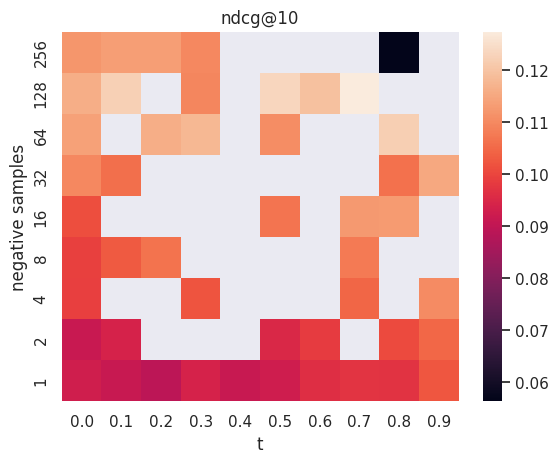

In [91]:
def fill_nans(array):
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(array)
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    return interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')
    

def show_map(metric):
    negatives = set()
    ts = set()
    for idx, row in data.iterrows():
        negatives.add(row['num_negatives'])
        ts.add(row['t'])
    negatives_sorted = sorted(list(negatives),reverse=True)
    ts_sorted = sorted(list(ts))
    neg_map = {}
    ts_map = {}
    for i in range(len(negatives_sorted)):
        neg_map[negatives_sorted[i]] = i
        
    for i in range(len(ts_sorted)):
        ts_map[ts_sorted[i]] = i
        
    result = np.empty((len(neg_map), len(ts_map)))
    result[:] = np.nan
    for idx, row in data.iterrows():
        num_negatives = row['num_negatives']
        t = row['t']
        result_metric = row[metric]
        if math.isnan(result_metric):
            continue
        x = neg_map[num_negatives]
        y = ts_map[t]
        result[x,y]=result_metric
    #result = fill_nans(result)
    #print(fill_nans(result))
    s=sns.heatmap(result[:,:-1], xticklabels=ts_sorted[:-1], yticklabels=negatives_sorted)
    s.set(xlabel='t')
    s.set(ylabel='negative samples')
    s.set(title=metric)

show_map('ndcg@10')